# Hodking-Huxley Model 

Full model is given by equations for m,n,h given by calculated alpha and beta parameters. 
Additionally there is given an equation from the currents in equivalent ciurcut

<equation>

List of helper functions and constans:

In [1]:
##Hodgkin-Huxley Model - class 2

#Setup
import matplotlib.pyplot as plt
import numpy as np
from peakdetect import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (50.0, 15.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Constants
C_m  =   0.1 #membrane capacitance, in uF/cm^2
g_Na = 120.0 #maximum conducances, in mS/cm^2
g_K  =  36.0
g_L  =   0.3
E_Na =  55.0 #Nernst reversal potentials, in mV
E_K  = -75.0
E_L  = -69

##non-linear paramiters alfa and beta
def alpha_m(u): return (2.5 - 0.1 * (u + 65)) / (np.exp(2.5 - 0.1 * (u + 65)) - 1)
def alpha_n(u): return (0.1 - 0.01 * (u + 65)) / (np.exp(1 - 0.1 * (u + 65)) - 1)
def alpha_h(u): return (0.07 * np.exp((-u - 65) / 20))
def beta_m(u):  return 4 * np.exp((-u - 65) / 18)
def beta_n(u):  return 0.125 * np.exp((-u - 65) / 80)
def beta_h(u):  return 1 / (np.exp(3 - 0.1 * (u + 65)) + 1)

#Membrane currents
def I_Na(u, m, h): return g_Na * m**3 * h * (u - E_Na)  #sodium channel
def I_K (u, n   ): return g_K  * n**4     * (u - E_K)   #potas
def I_L (u      ): return g_L             * (u - E_L)

# F: < m,n,h>
def dm_du(m, u): return alpha_m(u) * (1 - m) - beta_m(u) * m
def dn_du(n, u): return alpha_n(u) * (1 - n) - beta_n(u) * n
def dh_du(h, u): return alpha_h(u) * (1 - h) - beta_h(u) * h
def du_du(u, m, n, h, I=0): return (I_Na(u, m, h) + I_K(u, n) + I_L(u) - I)/ -C_m

#compute steady state values - system specification (starting points)
def MSS(u): return alpha_m(u) / (alpha_m(u) + beta_m(u))
def NSS(u): return alpha_n(u) / (alpha_n(u) + beta_n(u))
def HSS(u): return alpha_h(u) / (alpha_h(u) + beta_h(u))


## Current sources 


In [2]:
def iinj_rising(vec, t_rising, dt, Imax):
    istep = np.arange(0, t_rising, dt)
    istep = istep / (t_rising / Imax)

    iinj = np.ones_like(vec) * Imax
    iinj[0 : istep.shape[0]] = istep
    return iinj

def iinj_f(vec):
    I = lambda t: 15 + np.sin(2 * np.pi * 1e-3 * t)
    vfunc = np.vectorize(I)
    return vfunc(vec)

## Plotting function

In [3]:
def plot_all(t, U, M, N, H, iinj, peaks=True):
    #findpeak
    if peaks:
        maxtab, mintab = peakdet(U, 1e-3)
        i = array(maxtab)[:,0].astype(int)

    #plot
    fig, axes = plt.subplots(3, 1, figsize=(12, 4))
    #plot injected current
    axes[0].plot(t, iinj, label="Iinj")
    axes[0].grid(True)
    axes[0].set_ylabel('I[uA]')
    axes[0].set_title("Injected current")

    #plot membtane potential
    axes[1].plot(t, U, label="U")
    if peaks: axes[1].plot(t[i], U[i], '*')
    axes[1].grid(True)
    axes[1].set_ylabel('U[mV]')
    axes[1].set_title("Membrane potential")

    #plot steady state values
    axes[2].plot(t, M, label="M")
    axes[2].plot(t, N, label="N")
    axes[2].plot(t, H, label="H")
    axes[2].set_xlabel('t[ms]')
    axes[2].grid(True)
    axes[2].set_ylabel('Steady state val')
    axes[2].set_title("Steady state values")
    plt.show()
    #return fig, axes


## HH Model as a function


In [4]:
def HHModel(I, m0, n0, h0, u0, time):
    M = np.zeros_like(time)
    N = np.zeros_like(time)
    H = np.zeros_like(time)
    U = np.zeros_like(time)
    M[0], N[0], H[0], U[0] = m0, n0, h0, u0

    if not type(I) is np.ndarray:
        I = np.ones_like(time) * I

    #evolution of state values over time
    for t in range(0, len(time)-1):
        M[t+1] = M[t] + dm_du(M[t], U[t]) * dt
        N[t+1] = N[t] + dn_du(N[t], U[t]) * dt
        H[t+1] = H[t] + dh_du(H[t], U[t]) * dt
        U[t+1] = U[t] + du_du(U[t], M[t+1], N[t+1], H[t+1], I[t]) * dt

    return U, M, N, H, I

## Initial states

In [5]:
u0 = -70
tl = 500
dt = 1e-3
t = np.arange(0, tl, dt)

#starting points - system specification
m0 = MSS(u0) 
n0 = NSS(u0)
h0 = HSS(u0)


## Model tests
1. Simulation of the system for 500ms with a constant input current I = 0, I = 8.5 and I = 15 with dt = 0.001

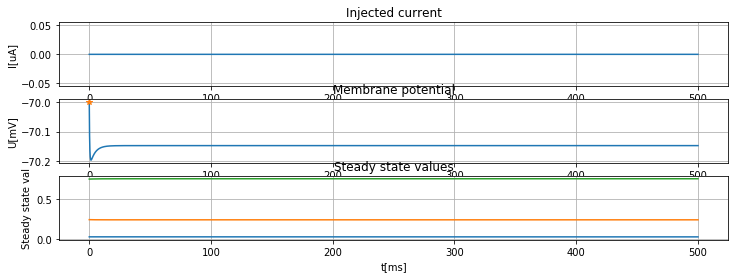

In [6]:
U, M, N, H, iinj = HHModel(0, MSS(u0), NSS(u0), HSS(u0), u0, t)
plot_all(t, U, M, N, H, iinj)

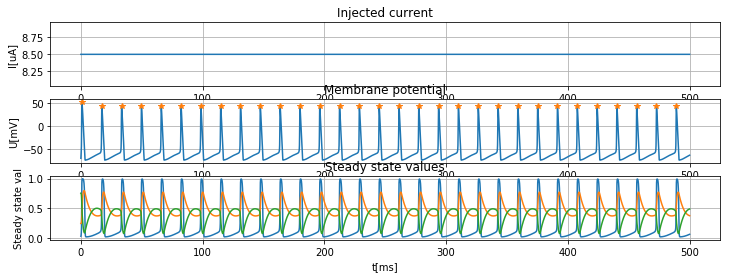

In [7]:
U, M, N, H, iinj = HHModel(8.5, MSS(u0), NSS(u0), HSS(u0), u0, t)
plot_all(t, U, M, N, H, iinj)

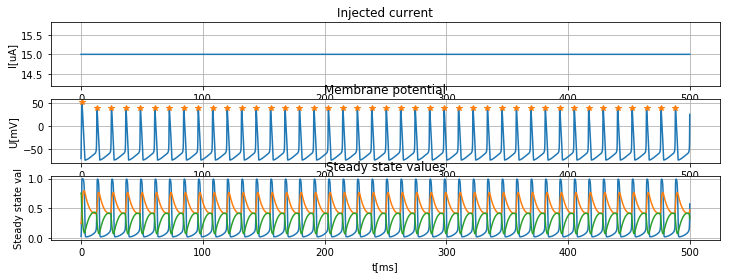

In [8]:
U, M, N, H, iinj = HHModel(15, MSS(u0), NSS(u0), HSS(u0), u0, t)
plot_all(t, U, M, N, H, iinj)

2. Simulation of the system with an input current that starts at 0 and ramps up to 8.5 over a time of 10ms, 25ms, 250ms. At which ramp steepness does the neuron start to fire? 

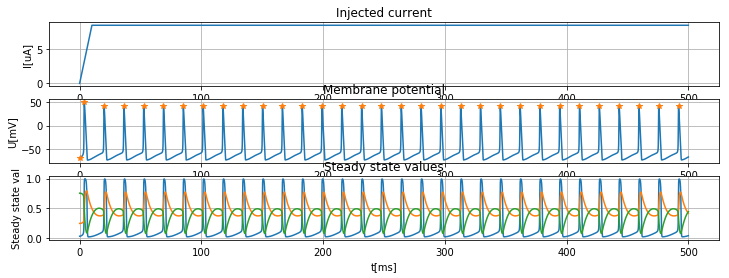

In [9]:
I10  = iinj_rising(t, 10 , 1e-3, 8.5)
I25  = iinj_rising(t, 25 , 1e-3, 8.5)
I250 = iinj_rising(t, 250, 1e-3, 8.5)

U, M, N, H, iinj = HHModel(I10, MSS(u0), NSS(u0), HSS(u0), u0, t)
plot_all(t, U, M, N, H, iinj)

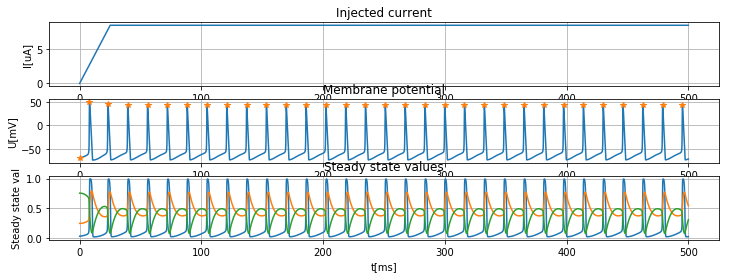

In [10]:
U, M, N, H, iinj = HHModel(I25, MSS(u0), NSS(u0), HSS(u0), u0, t)
plot_all(t, U, M, N, H, iinj)

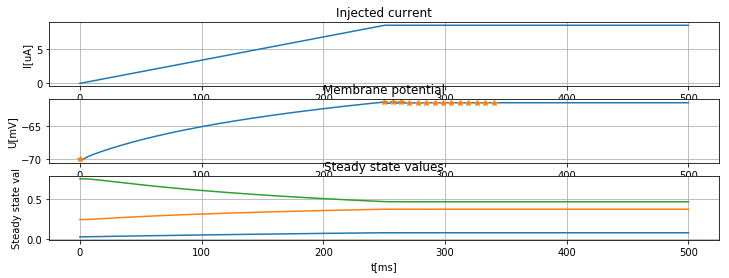

In [11]:
U, M, N, H, iinj = HHModel(I250, MSS(u0), NSS(u0), HSS(u0), u0, t)
plot_all(t, U, M, N, H, iinj)

## Firing rate and sinusoidal input current

3. Simulate the system with a time-varying input current I = 15+sin(2*pi*0.001*t) for 2000ms
and determine how the firing rate changes over time, i.e. how the input signal is encoded in
the model neuron’s response.

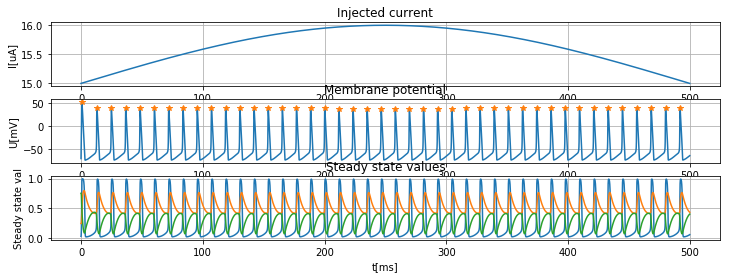

In [12]:
Isin = iinj_f(t)
U, M, N, H, iinj = HHModel(Isin, MSS(u0), NSS(u0), HSS(u0), u0, t)
plot_all(t, U, M, N, H, iinj)